## **Importing Libraries**

Importing all the libraries required for reading the datafile, processing the data, required ML models to train and test.

* **LabelEncoder** - Onehotencoding the labels, finding unique classes and converting to a number representation between 0 to (n-1) unique classes.

In [1]:
# Importing libraries required for handling the data
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

# Importing libraries for preprocessing
from sklearn.preprocessing import LabelEncoder

# Importing metrics library
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Importing ML Models
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Importing libraries for LSTM Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Uploading and reading the data files provided**

**Uploading the Datafile**<br>

*   Historical Product Demand.csv



In [2]:
uploaded = files.upload()

Saving Historical_Product_Demand.csv to Historical_Product_Demand.csv


**Reading the uploaded data files**

In [3]:
path = io.BytesIO(uploaded['Historical_Product_Demand.csv'])
df = pd.read_csv(path)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


## **Dataset Preparation**
Dropping any rows with NA values as they are noisy for training/testing a ML model.<br>
Setting a seed for reproducibility of results.<br>
Order_Demand was string with some parenthesis, removed them and made the column of type int. <br>
Changed the type of the date column from string to a datetime format.<br>
Used the date column as the index for the dataframe as its a time series data. Also sorted the dataset based on the date.<br>

In [4]:
# fix random seed for reproducibility
np.random.seed(7)
#Dropping NA values
df.dropna(inplace=True)
# Setting the Order_Demand type to as type int
df["Order_Demand"] = df["Order_Demand"].replace('[(*)*,]', '', regex=True).astype(int)
df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d")
df = df.set_index("Date")
df.sort_index(inplace=True)
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2011-01-08,Product_0965,Whse_A,Category_006,2
2011-05-31,Product_1724,Whse_A,Category_003,108
2011-06-24,Product_1521,Whse_S,Category_019,85000
2011-06-24,Product_1521,Whse_S,Category_019,7000
2011-09-02,Product_1507,Whse_C,Category_019,1250


## **Exploring and visualizing the dataset**

* Plotting graph for product counts in every warehouse
* Plotting graph for product counts in every product category

Counting products in every Warehouse and displaying the 5 maximum counts.

In [5]:
df['Warehouse'].value_counts().head()

Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64

Plotting a count plot based on the counts.

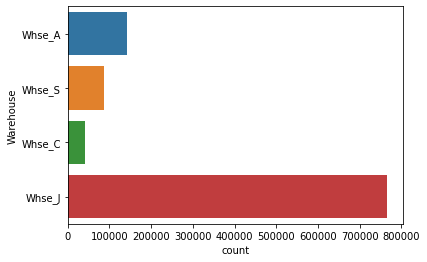

In [6]:
sns.countplot(y="Warehouse", data=df)

Counting products in every product category and displaying the 5 maximum counts.

In [7]:
df['Product_Category'].value_counts().head()

Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Name: Product_Category, dtype: int64

Plotting a count plot based on the category counts.

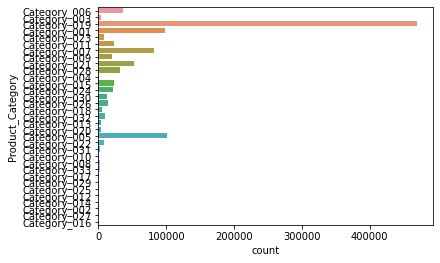

In [8]:
sns.countplot(y="Product_Category", data=df)

Counting every product and displaying the 5 maximum counts.

In [9]:
df['Product_Code'].value_counts().head()

Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
Name: Product_Code, dtype: int64

## **Pre-processing the data**
Creating label encoders and using them to fit and transform the features we want to do the one hot encoding on.

* Product Label - Converting the product name to a unique number, as I restrict myself to one product only there is no need for this but still is done.
* Warehouse Label - Converting the Warehouse to a unique number, for future work when a model is trained for all the products available in all the warehouses.
* Category Label - Converting the product category to a unique number, for future work can be used to predict a products demand given the product's category demand.

In [10]:
productLabel = LabelEncoder()
warehouseLabel = LabelEncoder()
categoryLabel = LabelEncoder()

In [11]:
df['Product_Code_Label'] = productLabel.fit_transform(df["Product_Code"])
df['Warehouse_Label'] = warehouseLabel.fit_transform(df["Warehouse"])
df['Product_Category_Label'] = categoryLabel.fit_transform(df["Product_Category"])
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,Product_Code_Label,Warehouse_Label,Product_Category_Label
Date,,,,,,,
2011-01-08,Product_0965,Whse_A,Category_006,2,954,0,5
2011-05-31,Product_1724,Whse_A,Category_003,108,1713,0,2
2011-06-24,Product_1521,Whse_S,Category_019,85000,1510,3,18
2011-06-24,Product_1521,Whse_S,Category_019,7000,1510,3,18
2011-09-02,Product_1507,Whse_C,Category_019,1250,1496,1,18


Restricting to a single product, in this case the product with the highest number of data points as seen from the counts earlier is product_1359 with a code label of 1348.

In [12]:
df_p = df.loc[df['Product_Code']=='Product_1359']
print("The whole Dataset has",df.shape[0],"rows, and",df.shape[1],"columns.")
print("For Product_Code = Product_1359 the Dataset has",df_p.shape[0],"rows, and",df_p.shape[1],"columns.")
df_p.head()

The whole Dataset has 1037336 rows, and 7 columns.
For Product_Code = Product_1359 the Dataset has 16936 rows, and 7 columns.


,Product_Code,Warehouse,Product_Category,Order_Demand,Product_Code_Label,Warehouse_Label,Product_Category_Label
Date,,,,,,,
2012-01-05,Product_1359,Whse_J,Category_019,25000,1348,2,18
2012-01-05,Product_1359,Whse_J,Category_019,1000,1348,2,18
2012-01-05,Product_1359,Whse_J,Category_019,10000,1348,2,18
2012-01-05,Product_1359,Whse_J,Category_019,5000,1348,2,18
2012-01-05,Product_1359,Whse_J,Category_019,150000,1348,2,18


The specified product falls under one category, and is available only in one warehouse as we can see from the following output.

In [13]:
print(df_p.loc[df_p['Product_Category_Label']!=18].shape)
print(df_p.loc[df_p['Warehouse_Label']!=2].shape)
print(df_p.loc[df_p['Product_Code_Label']!=1348].shape)

(0, 7)
(0, 7)
(0, 7)


The order demand as a time series data for a single product sorted on the dates.

In [14]:
timeSeries = df.loc[df['Product_Code_Label'] == 1348]['Order_Demand']
timeSeries.head()

Date
2012-01-05     25000
2012-01-05      1000
2012-01-05     10000
2012-01-05      5000
2012-01-05    150000
Name: Order_Demand, dtype: int64

Resampling the sorted time series data to calculate the total Daily demand of the specified product and printing the head.

In [15]:
timeSeries_Daily = timeSeries.resample('D').sum().to_frame() # resample and sum values from the same day
# timeSeries_Daily.drop(timeSeries_Daily[timeSeries_Daily['Order_Demand'] == 0].index,inplace=True) # Can drop the days with 0 as it will be more consistent but will not be realistic
print("There are",timeSeries_Daily.shape[0],"days with the following demand:")
timeSeries_Daily.head()

There are 1829 days with the following demand:


,Order_Demand
Date,
2012-01-05,702000
2012-01-06,676000
2012-01-07,0
2012-01-08,0
2012-01-09,0


Visualizing the per day demand of the product.

[Text(0, 0.5, 'Daily Demand '), Text(0.5, 0, 'Date')]

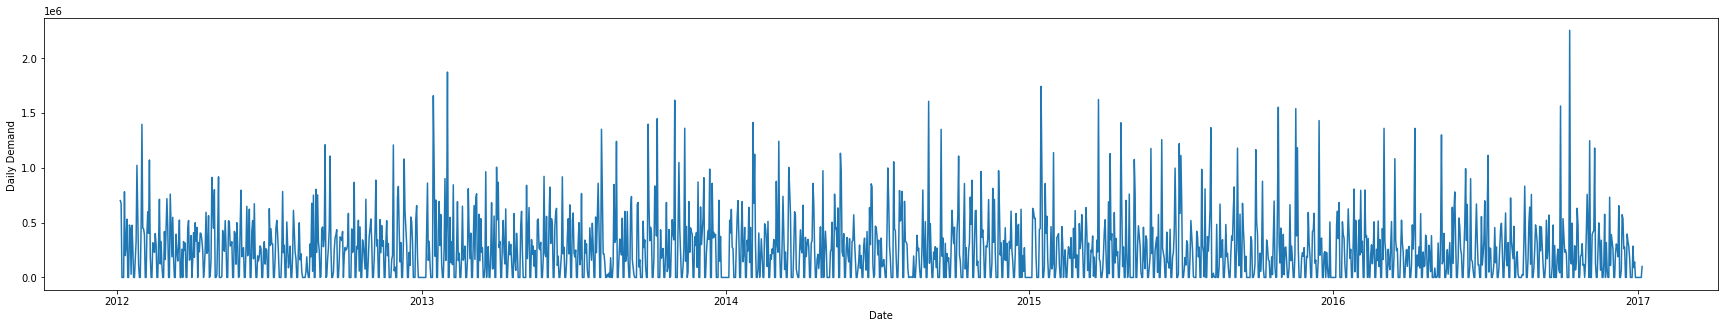

In [16]:
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=timeSeries_Daily.index,y='Order_Demand', data=timeSeries_Daily)
ax.set(ylabel='Daily Demand ', xlabel='Date')

Resampling the sorted time series data to calculate the total Weekly demand of the specified product and printing the head.

In [17]:
timeSeries_Weekly = timeSeries.resample('W').sum().to_frame()
print("There are",timeSeries_Weekly.shape[0],"Weeks with the following demand:")
timeSeries_Weekly.head(5)

There are 262 Weeks with the following demand:


,Order_Demand
Date,
2012-01-08,1378000
2012-01-15,1799000
2012-01-22,1710000
2012-01-29,2171000
2012-02-05,3138000


Visualizing the Weekly Demand of the product.


[Text(0, 0.5, 'Weekly Demand '), Text(0.5, 0, 'Date')]

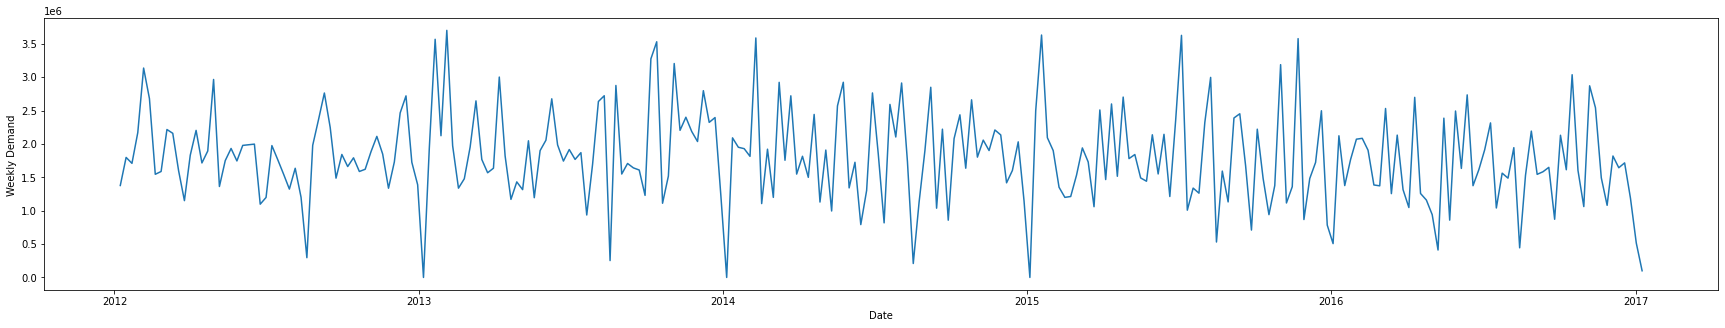

In [18]:
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=timeSeries_Weekly.index,y='Order_Demand',data=timeSeries_Weekly)
ax.set(ylabel='Weekly Demand ', xlabel='Date')

Resampling the sorted time series data to calculate the total Monthly demand of the specified product and printing the head.

In [19]:
timeSeries_Monthly = timeSeries.resample('M').sum().to_frame()
print("There are",timeSeries_Monthly.shape[0],"months with the following demand:")
timeSeries_Monthly.head(5)

There are 61 months with the following demand:


,Order_Demand
Date,
2012-01-31,8911000
2012-02-29,8131000
2012-03-31,7775000
2012-04-30,8960000
2012-05-31,8475000


Visualizing the Monthly Demand of the product.


[Text(0, 0.5, 'Monthly Demand '), Text(0.5, 0, 'Date')]

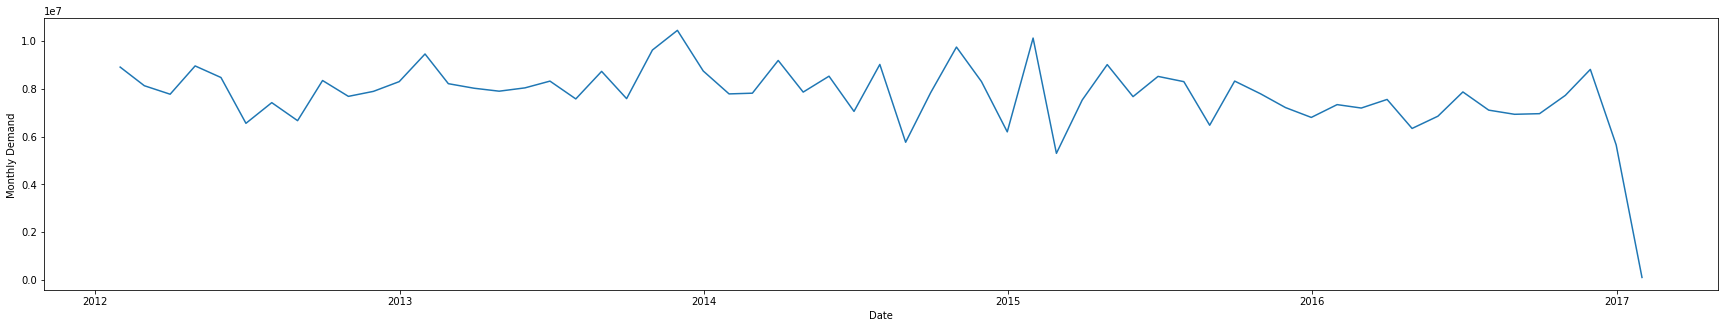

In [20]:
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=timeSeries_Monthly.index,y='Order_Demand',data=timeSeries_Monthly)
ax.set(ylabel='Monthly Demand ', xlabel='Date')

## **Training and Testing Forecasting Models**

**Models Used**

* Autoregressive Integrated Moving Average (ARIMA)
* Seasonal Autoregressive Integrated Moving Average (SARIMAX)
* Neural Network - Long Short Term Memory (LSTM)

Training and testing the models on following Order Demands:

1.   Daily
2.   Weekly
3. Monthly

Also plotted the graphs for a visual representation of the predicted (with a lag of 1) and actual demands.

* **Actual Demands -- Blue Line**
* **Predicted Demand -- Red Line**


ARIMA on per day demand of the product, the coefficient of confidence is 0.2403

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                 1829
Model:                    ARMA(2, 10)   Log Likelihood              -25394.413
Method:                       css-mle   S.D. of innovations         258642.577
Date:                Tue, 13 Oct 2020   AIC                          50816.827
Time:                        04:26:38   BIC                          50893.988
Sample:                    01-05-2012   HQIC                         50845.287
                         - 01-06-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.583e+05   6131.704     42.129      0.000    2.46e+05     2.7e+05
ar.L1.Order_Demand      1.2468      0.000   5161.957      0.000       1.246       1.247
ar.L2.Order_Dema

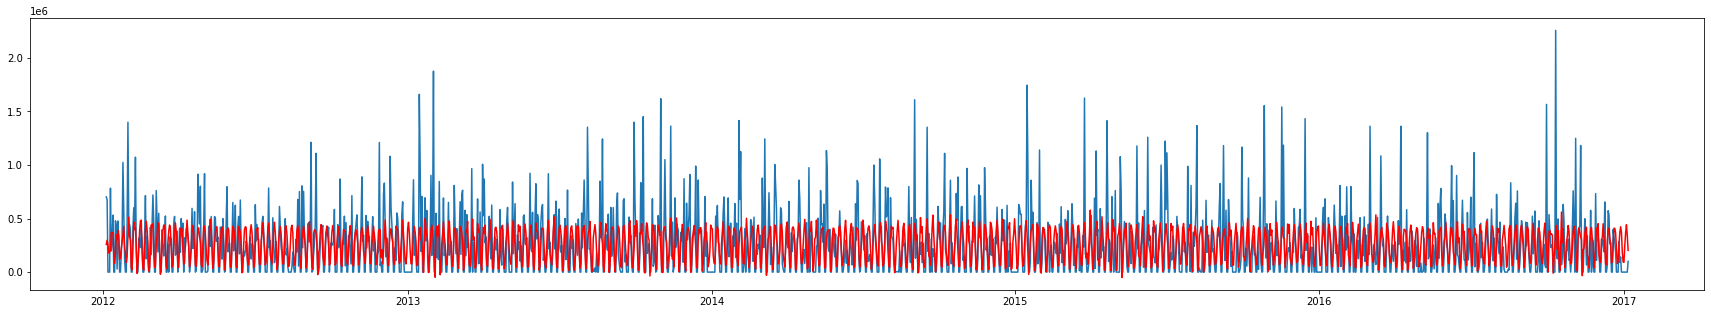

0.2403019289869449

In [21]:
model_arima_d = ARIMA(timeSeries_Daily, order=(2,0,10)).fit()
print(model_arima_d.summary())
preds_arima_d = model_arima_d.predict()

ax = plt.figure(figsize=(30,5))
plt.plot(timeSeries_Daily)
plt.plot(preds_arima_d, color='red')
plt.show()
r2_score(timeSeries_Daily, preds_arima_d)

ARIMA on weekly demands of the product, the coefficient of confidence is 6.28%. The graph shows a decent fit.

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                  262
Model:                    ARMA(2, 10)   Log Likelihood               -3888.795
Method:                       css-mle   S.D. of innovations         670395.933
Date:                Tue, 13 Oct 2020   AIC                           7805.589
Time:                        04:27:00   BIC                           7855.546
Sample:                    01-08-2012   HQIC                          7825.668
                         - 01-08-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.803e+06    3.4e+04     53.079      0.000    1.74e+06    1.87e+06
ar.L1.Order_Demand     -0.1316      0.049     -2.697      0.007      -0.227      -0.036
ar.L2.Order_Dema

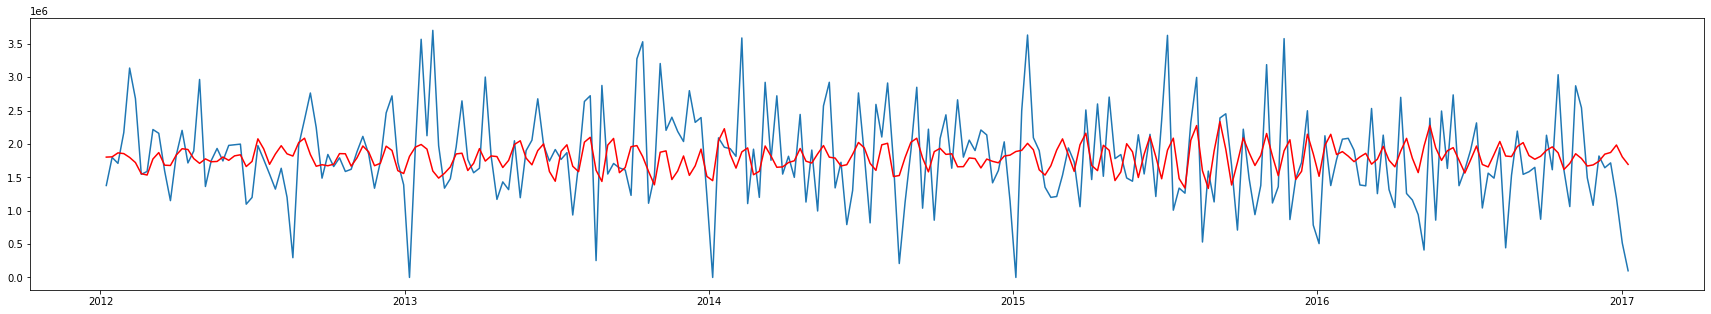

0.06287656460917335

In [22]:
model_arima_w = ARIMA(timeSeries_Weekly, order=(2,0,10)).fit()
print(model_arima_w.summary())
preds_arima_w = model_arima_w.predict()

plt.figure(figsize=(30,5))
plt.plot(timeSeries_Weekly)
plt.plot(preds_arima_w, color='red')
plt.show()
r2_score(timeSeries_Weekly, preds_arima_w)

ARIMA on Monthly demands of the product, this has the highest coefficient of confidence of 24.17%. With the ARIMA model, the monthly time series data works well, we can also see the graph with a few places with very accurate predictions.

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                   61
Model:                    ARMA(0, 10)   Log Likelihood                -944.725
Method:                       css-mle   S.D. of innovations        1185136.836
Date:                Tue, 13 Oct 2020   AIC                           1913.449
Time:                        04:27:43   BIC                           1938.780
Sample:                    01-31-2012   HQIC                          1923.376
                         - 01-31-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                7.745e+06    3.1e+05     25.014      0.000    7.14e+06    8.35e+06
ma.L1.Order_Demand      0.2542      0.331      0.768      0.446      -0.394       0.903
ma.L2.Order_Dema

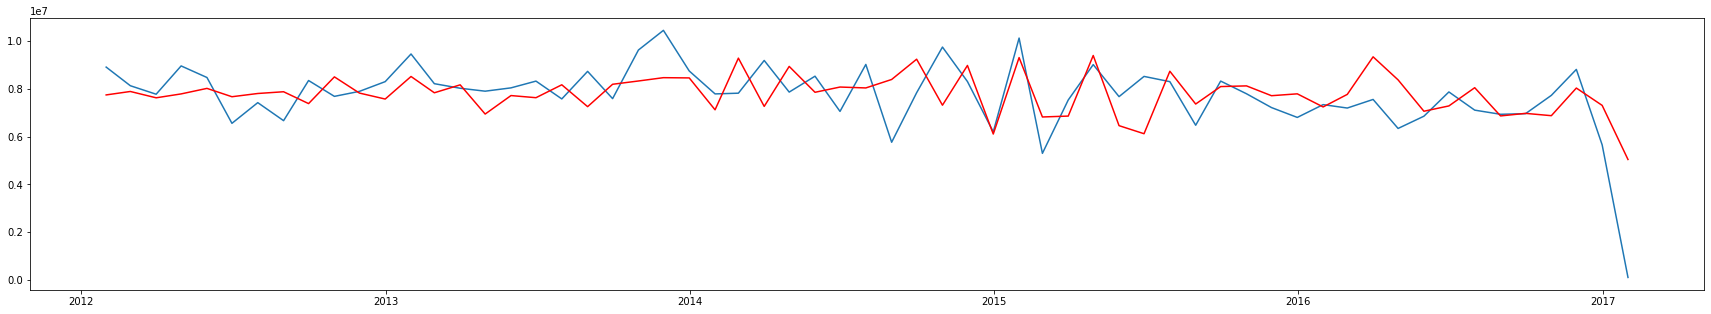

0.2417224538794791

In [23]:
model_arima_m = ARIMA(timeSeries_Monthly, order=(0,0,10)).fit()
print(model_arima_m.summary())
preds_arima_m = model_arima_m.predict()

plt.figure(figsize=(30,5))
plt.plot(timeSeries_Monthly)
plt.plot(preds_arima_m, color='red')
plt.show()
r2_score(timeSeries_Monthly, preds_arima_m)

SARIMAX on per day demand of the product, the coefficient of confidence is 0.2152. With the seasonal ARIMA we see that the daily forcasting has the highest coefficient of confidence 

                           Statespace Model Results                           
Dep. Variable:           Order_Demand   No. Observations:                 1829
Model:              SARIMAX(2, 0, 10)   Log Likelihood              -25426.630
Date:                Tue, 13 Oct 2020   AIC                          50881.259
Time:                        04:28:14   BIC                          50958.421
Sample:                    01-05-2012   HQIC                         50909.720
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.359e+05   1.57e-07    1.5e+12      0.000    2.36e+05    2.36e+05
ar.L1          1.2469      0.000   5700.616      0.000       1.246       1.247
ar.L2         -1.0000   8.15e-05  -1.23e+04      0.0

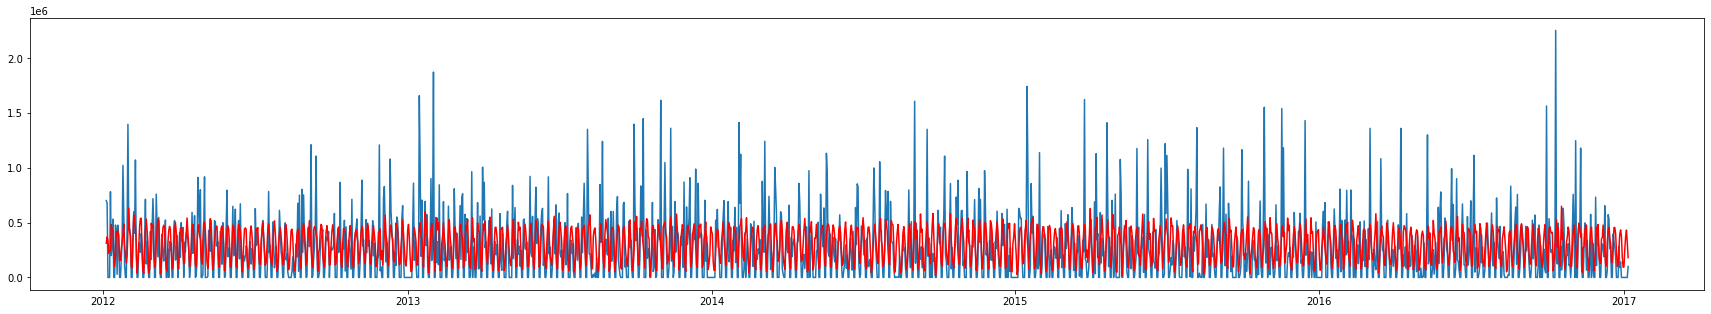

0.21525833171037168

In [24]:
mod_d = sm.tsa.statespace.SARIMAX(timeSeries_Daily, trend='c', order=(2,0,10)).fit(disp=False, maxiter=100)
preds_d = mod_d.predict()
print(mod_d.summary())

plt.figure(figsize=(30,5))
plt.plot(timeSeries_Daily)
plt.plot(preds_d, color='red')
plt.show()
r2_score(timeSeries_Daily, preds_d)

SARIMAX on Weekly demands of the product, the coefficient of confidence is 0.0445

                           Statespace Model Results                           
Dep. Variable:           Order_Demand   No. Observations:                  262
Model:              SARIMAX(2, 0, 10)   Log Likelihood               -3891.336
Date:                Tue, 13 Oct 2020   AIC                           7810.673
Time:                        04:28:15   BIC                           7860.630
Sample:                    01-08-2012   HQIC                          7830.751
                         - 01-08-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.963e+06   3.07e-08   6.38e+13      0.000    1.96e+06    1.96e+06
ar.L1          0.2042      0.429      0.476      0.634      -0.637       1.045
ar.L2         -0.2911      0.426     -0.684      0.4

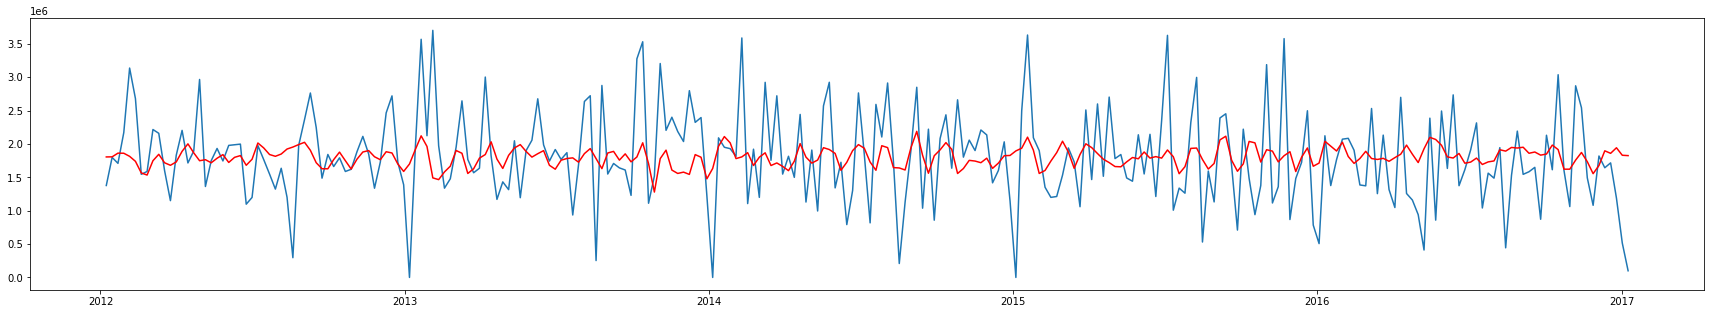

0.044544583957841444

In [25]:
mod_w = sm.tsa.statespace.SARIMAX(timeSeries_Weekly, trend='c', order=(2,0,10)).fit(disp=False)
preds_w = mod_w.predict()
print(mod_w.summary())

plt.figure(figsize=(30,5))
plt.plot(timeSeries_Weekly)
plt.plot(preds_w, color='red')
plt.show()
r2_score(timeSeries_Weekly, preds_w)

SARIMAX on Monthly demand of the product, the coefficient of confidence is 0.2023

                           Statespace Model Results                           
Dep. Variable:           Order_Demand   No. Observations:                   61
Model:              SARIMAX(1, 0, 10)   Log Likelihood                -948.426
Date:                Tue, 13 Oct 2020   AIC                           1922.852
Time:                        04:28:17   BIC                           1950.294
Sample:                    01-31-2012   HQIC                          1933.607
                         - 01-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.548e+06   6.94e-08   9.43e+13      0.000    6.55e+06    6.55e+06
ar.L1          0.1490      0.073      2.048      0.041       0.006       0.292
ma.L1          0.0254      0.367      0.069      0.9

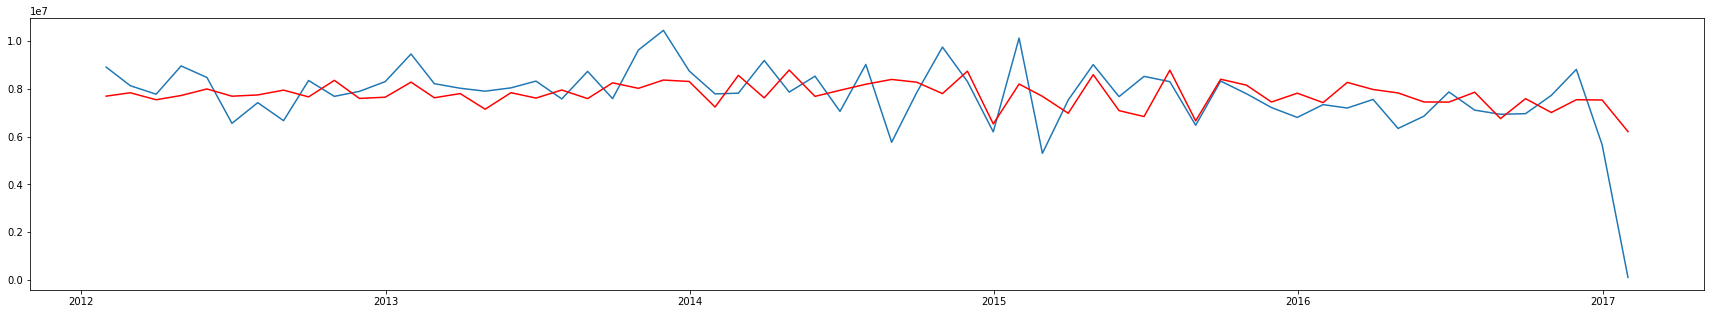

0.20239560465022022

In [26]:
mod_m = sm.tsa.statespace.SARIMAX(timeSeries_Monthly, trend='c', order=(1,0,10)).fit(disp=False, maxiter=80)
preds_m = mod_m.predict()
print(mod_m.summary())

plt.figure(figsize=(30,5))
plt.plot(timeSeries_Monthly)
plt.plot(preds_m, color='red')
plt.show()
r2_score(timeSeries_Monthly, preds_m)

**Trying a LSTM Neural Network**

Using the Daily demand values, I created a X and y dataset, where X=t and y = t+1 for daily demands. So X has the demand for the current day, and Y at the same index has the demand for the next day. This gives us a dataset with given todays demand predict the demand of the product for tommorrow, we can change the look back value to increase the number of days to look past at. If we do increase the lookback we will have to generate the data for each columns upto that lookback and append them together for training and testing.<br>

The data is also scaled before splitting as a Neural network is benefited a lot when scaled data is used.

The training and testing data is also reshaped in the form of [samples, timesteps, features] as the Neural Network (LSTM Layer) requires this shape as input.

In [27]:
look_back = 1

scaler = MinMaxScaler(feature_range=(0, 1))
timeSeries_Daily = scaler.fit_transform(timeSeries_Daily)

X, y = timeSeries_Daily[:-(look_back)],timeSeries_Daily[look_back:]
print(X.shape,y.shape)

# Splitting the data into train and test sets
splitIndex = math.floor(len(X)*0.8)
X_train = X[:splitIndex]
X_test = X[splitIndex:]
y_train = y[:splitIndex]
y_test = y[splitIndex:]

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

(1828, 1) (1828, 1)


Creating and fitting the neural network

Created the LSTM NN using keras, its a sequential model with the first layer being an lstm layer, the second layer is a dense layer with 10 neurons, and the third one is a dense layer (output layer) with one neuron for the output. The loss function is mse and adam optimizer from keras is used.

In [28]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1462/1462 - 3s - loss: 0.0178
Epoch 2/100
1462/1462 - 3s - loss: 0.0176
Epoch 3/100
1462/1462 - 3s - loss: 0.0175
Epoch 4/100
1462/1462 - 3s - loss: 0.0176
Epoch 5/100
1462/1462 - 3s - loss: 0.0175
Epoch 6/100
1462/1462 - 3s - loss: 0.0175
Epoch 7/100
1462/1462 - 3s - loss: 0.0175
Epoch 8/100
1462/1462 - 3s - loss: 0.0175
Epoch 9/100
1462/1462 - 3s - loss: 0.0175
Epoch 10/100
1462/1462 - 3s - loss: 0.0175
Epoch 11/100
1462/1462 - 3s - loss: 0.0173
Epoch 12/100
1462/1462 - 3s - loss: 0.0174
Epoch 13/100
1462/1462 - 3s - loss: 0.0174
Epoch 14/100
1462/1462 - 3s - loss: 0.0174
Epoch 15/100
1462/1462 - 3s - loss: 0.0173
Epoch 16/100
1462/1462 - 3s - loss: 0.0173
Epoch 17/100
1462/1462 - 3s - loss: 0.0174
Epoch 18/100
1462/1462 - 3s - loss: 0.0172
Epoch 19/100
1462/1462 - 3s - loss: 0.0173
Epoch 20/100
1462/1462 - 3s - loss: 0.0173
Epoch 21/100
1462/1462 - 3s - loss: 0.0173
Epoch 22/100
1462/1462 - 3s - loss: 0.0172
Epoch 23/100
1462/1462 - 3s - loss: 0.0173
Epoch 24/100
1462/14

Using the trained LSTM Neural Network I predicted on the test dataset, which gave a Root Mean Squared Error of 283297.425 which is quite high. Future work could include improving the LSTM network for better results which could include increasing the epochs, or changing the architectures (Layers and neurons) of the network or any other hyper parameter optimizations.

Score: 283297.42533291224 RMSE


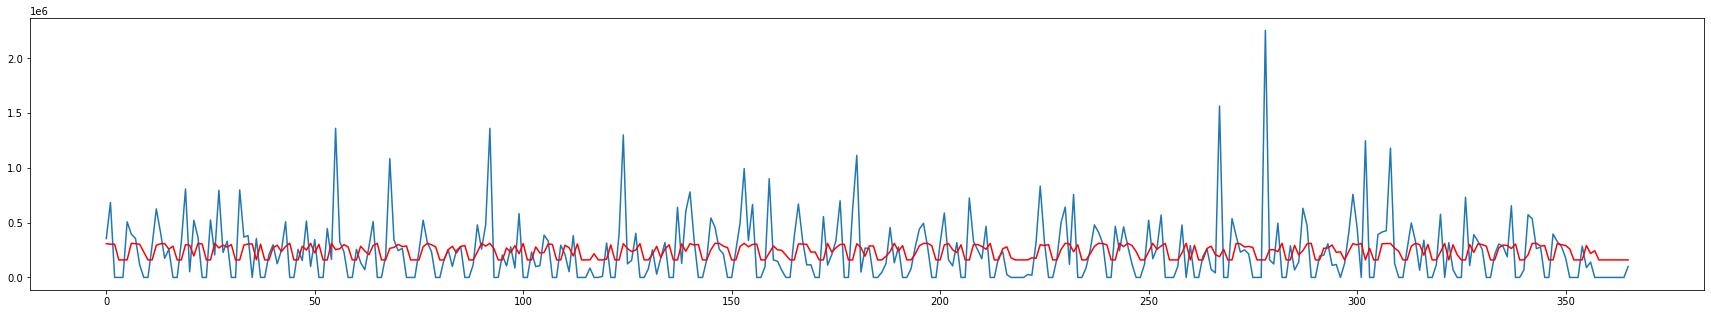

In [29]:
preds_lstm = model.predict(X_test)

preds_lstm = scaler.inverse_transform(preds_lstm)
y_test = scaler.inverse_transform(y_test)

score = math.sqrt(mean_squared_error(y_test, preds_lstm))
print('Score:', score, 'RMSE')

plt.figure(figsize=(30,5))
plt.plot(y_test)
plt.plot(preds_lstm, color='red')
plt.show()

**Conclusion:**
The autoregressive integrated moving average works good for forecasting models, but the highest confidence score achieved for the specific product was 24.17% using the ARIMA model on the Monthly forecasting which is not great. There are a few places where the predictions are exactly the same as the actual demand.<br>

The LSTM network did do a decent job predicting on the test data set, I thought the NN will do a way better job but probably this can be improved and can be done as future work.

**Future Work:**
To improve the neural network we can increase the timesteps to look back, this will increase the number of features as input to the neural network, as every timestep back will have a column of its own. I think this will improve the predictions of the model a lot.<br>
Including all the products given in the dataset will also change the results, but with all the features we might be able to use a categories demand to predict the demand of the product falling in that category, which could improve our prediction accuracy.